In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class MosaicDataset1(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [3]:
data = np.load("type4_data.npy",allow_pickle=True)

In [4]:
mosaic_list_of_images = data[0]["mosaic_list"]
mosaic_label = data[0]["mosaic_label"]
fore_idx = data[0]["fore_idx"]

In [5]:
batch = 250
msd = MosaicDataset1(mosaic_list_of_images, mosaic_label, fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [6]:
class Focus_deep(nn.Module):
    '''
       deep focus network averaged at zeroth layer
       input : elemental data
    '''
    def __init__(self,inputs,output,K,d):
        super(Focus_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.K = K
        self.d  = d
        self.linear1 = nn.Linear(self.inputs,50)  #,self.output)
        self.linear2 = nn.Linear(50,50)
        self.linear3 = nn.Linear(50,self.output) 
    def forward(self,z):
        batch = z.shape[0]
        x = torch.zeros([batch,self.K],dtype=torch.float64)
        y = torch.zeros([batch,50], dtype=torch.float64)
        features = torch.zeros([batch,self.K,50],dtype=torch.float64)
        x,y = x.to("cuda"),y.to("cuda")
        features = features.to("cuda")
        for i in range(self.K):
            alp,ftrs = self.helper(z[:,i] )  # self.d*i:self.d*i+self.d
            x[:,i] = alp[:,0]
            features[:,i]  = ftrs 
        x = F.softmax(x,dim=1)   # alphas
        for i in range(self.K):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],features[:,i])  # self.d*i:self.d*i+self.d
        return y , x 
    def helper(self,x):
      x = self.linear1(x)
      x1 = F.tanh(x)
      x = F.relu(x) 
      x = F.relu(self.linear2(x))
      x = self.linear3(x)
      #print(x1.shape)
      return x,x1


In [7]:
class Classification_deep(nn.Module):
    '''
       input : elemental data
       deep classification module data averaged at zeroth layer
    '''
    def __init__(self,inputs,output):
        super(Classification_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.linear1 = nn.Linear(self.inputs,50)
        #self.linear2 = nn.Linear(6,12)
        self.linear2 = nn.Linear(50,self.output)

    def forward(self,x):
      x = F.relu(self.linear1(x))
      #x = F.relu(self.linear2(x))
      x = self.linear2(x)
      return x    

In [8]:
def calculate_attn_loss(dataloader,what,where,criter):
  what.eval()
  where.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      avg,alpha = where(inputs)
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())
      loss = criter(outputs, labels)
      r_loss += loss.item()
  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,analysis

In [9]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [10]:
number_runs = 20
FTPT_analysis = pd.DataFrame(columns = ["FTPT","FFPT", "FTPF","FFPF"])
for n in range(number_runs):
  print("--"*40)
  
  # instantiate focus and classification Model
  torch.manual_seed(n)
  where = Focus_deep(2,1,9,2).double()
  torch.manual_seed(n)
  what = Classification_deep(50,3).double()
  where = where.to("cuda")
  what = what.to("cuda")



  # instantiate optimizer
  optimizer_where = optim.Adam(where.parameters(),lr =0.01)
  optimizer_what = optim.Adam(what.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()
  acti = []
  analysis_data = []
  loss_curi = []
  epochs = 2500


  # calculate zeroth epoch loss and FTPT values
  running_loss,anlys_data = calculate_attn_loss(train_loader,what,where,criterion)
  loss_curi.append(running_loss)
  analysis_data.append(anlys_data)

  print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 

  # training starts 
  for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []
    running_loss = 0.0
    what.train()
    where.train()
    for i, data in enumerate(train_loader, 0):
      # get the inputs
      inputs, labels,_ = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")

      # zero the parameter gradients
      optimizer_where.zero_grad()
      optimizer_what.zero_grad()
      
      # forward + backward + optimize
      avg, alpha = where(inputs)
      outputs = what(avg)
      loss = criterion(outputs, labels)

      # print statistics
      running_loss += loss.item()
      loss.backward()
      optimizer_where.step()
      optimizer_what.step()

    running_loss,anls_data = calculate_attn_loss(train_loader,what,where,criterion)
    analysis_data.append(anls_data)
    print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
    loss_curi.append(running_loss)   #loss per epoch
    if running_loss<=0.01:
      break
  print('Finished Training run ' +str(n))
  analysis_data = np.array(analysis_data)
  FTPT_analysis.loc[n] = analysis_data[-1,:4]/30
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      images, labels,_ = data
      images = images.double()
      images, labels = images.to("cuda"), labels.to("cuda")
      avg, alpha = where(images)
      outputs  = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 3000 train images: %d %%' % (  100 * correct / total))
    

--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: [0 ] loss: 1.199
epoch: [1] loss: 1.203
epoch: [2] loss: 1.189
epoch: [3] loss: 1.176
epoch: [4] loss: 1.144
epoch: [5] loss: 1.031
epoch: [6] loss: 0.834
epoch: [7] loss: 0.546
epoch: [8] loss: 0.248
epoch: [9] loss: 0.149
epoch: [10] loss: 0.056
epoch: [11] loss: 0.042
epoch: [12] loss: 0.014
epoch: [13] loss: 0.010
epoch: [14] loss: 0.011
epoch: [15] loss: 0.009
Finished Training run 0
Accuracy of the network on the 3000 train images: 100 %
--------------------------------------------------------------------------------
epoch: [0 ] loss: 1.211
epoch: [1] loss: 1.190
epoch: [2] loss: 1.146
epoch: [3] loss: 0.965
epoch: [4] loss: 0.666
epoch: [5] loss: 0.344
epoch: [6] loss: 0.124
epoch: [7] loss: 0.048
epoch: [8] loss: 0.021
epoch: [9] loss: 0.009
Finished Training run 1
Accuracy of the network on the 3000 train images: 99 %
--------------------------------------------------------------------------------
epoch: [0 ] loss: 1.200
epoch: [1] loss: 1.195
epoch: [2] loss: 1.182
epo

In [11]:
# plt.figure(figsize=(6,6))
# plt.plot(np.arange(0,epoch+2,1),analysis_data[:,0],label="ftpt")
# plt.plot(np.arange(0,epoch+2,1),analysis_data[:,1],label="ffpt")
# plt.plot(np.arange(0,epoch+2,1),analysis_data[:,2],label="ftpf")
# plt.plot(np.arange(0,epoch+2,1),analysis_data[:,3],label="ffpf")

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



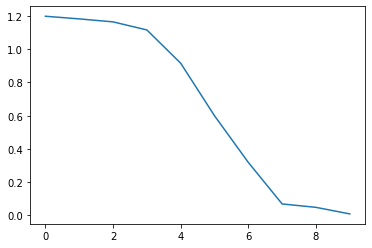

In [12]:
plt.plot(loss_curi)

In [13]:
np.mean(np.array(FTPT_analysis),axis=0)

array([9.05450000e+01, 9.40666667e+00, 4.66666667e-02, 1.66666667e-03])

In [14]:
FTPT_analysis.to_csv("synthetic_first.csv",index=False)

In [15]:
FTPT_analysis

,FTPT,FFPT,FTPF,FFPF
0,94.700000,5.300000,0.000000,0.000000
1,97.000000,2.933333,0.066667,0.000000
2,71.766667,28.133333,0.066667,0.033333
3,97.200000,2.733333,0.066667,0.000000
4,99.966667,0.033333,0.000000,0.000000
5,71.100000,28.900000,0.000000,0.000000
6,98.966667,1.000000,0.033333,0.000000
7,99.633333,0.300000,0.066667,0.000000
8,91.966667,7.966667,0.066667,0.000000
9,99.900000,0.100000,0.000000,0.000000
